In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **important note don't forget to restart the session after building MultiScaleDeformableAttention**

In [2]:
# build MultiScaleDeformableAttention
!cd /content/drive/MyDrive/models/dino/ops
!export TORCH_CUDA_ARCH_LIST="7.5;8.0;8.6;8.9"   # 7.5 for grand-challenge's online GPU (T4), 8.6 for 3090
!python /content/drive/MyDrive/models/dino/ops/setup.py build install

running build
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'MultiScaleDeformableAttention' extension
creating build/temp.linux-x86_64-cpyth

In [1]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [40]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import torch
import numpy as np
from models.unet.utils import load_state
from train_unet import SegmentationDataset, TransformedDataset, Preload
from models.unet.UNet import UNet
from models.unet.SE_UNet import SEUNet
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from scipy.ndimage import center_of_mass
import os

##### Plot Training Curves
def plot_unet_training(log_dir, model_name="U-Net"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    train_total = ea.Scalars("train_loss/total")
    val_total = ea.Scalars("validation_loss/total")
    train_dice = ea.Scalars("train_loss/dice")
    val_dice = ea.Scalars("validation_loss/dice")
    train_ce = ea.Scalars("train_loss/ce")
    val_ce = ea.Scalars("validation_loss/ce")

    steps = [e.step for e in train_total]

    plt.figure(figsize=(14, 6))

    # Plot total loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, [e.value for e in train_total], label="Train Total")
    plt.plot(steps, [e.value for e in val_total], label="Validation Total")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Total Loss")
    plt.legend()
    plt.grid(True)

    # Plot Dice and CE losses
    plt.subplot(1, 2, 2)
    plt.plot(steps, [e.value for e in train_dice], label="Train Dice")
    plt.plot(steps, [e.value for e in val_dice], label="Validation Dice")
    plt.plot(steps, [e.value for e in train_ce], label="Train CE")
    plt.plot(steps, [e.value for e in val_ce], label="Validation CE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Dice vs CE Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
#--------------------------------------------------------------------------------------
def evaluate_segmentation_model_enum9(model, dataloader, device='cuda', num_classes=9):
    model.eval()
    dice_scores = [[] for _ in range(num_classes)]
    iou_scores = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)

            for pred, gt in zip(preds, masks):
                for cls in range(num_classes):  # include background and out-of-quadrant
                    pred_inds = (pred == cls)
                    gt_inds = (gt == cls)

                    if gt_inds.sum() == 0 and pred_inds.sum() == 0:
                        continue

                    intersection = (pred_inds & gt_inds).sum().item()
                    union = (pred_inds | gt_inds).sum().item()
                    dice = (2. * intersection) / (pred_inds.sum().item() + gt_inds.sum().item() + 1e-8)
                    iou = intersection / (union + 1e-8)

                    dice_scores[cls].append(dice)
                    iou_scores[cls].append(iou)

    mean_dice_per_class = [np.mean(cls_dice) if cls_dice else 1.0 for cls_dice in dice_scores]
    mean_iou_per_class = [np.mean(cls_iou) if cls_iou else 1.0 for cls_iou in iou_scores]
    return np.mean(mean_iou_per_class), np.mean(mean_dice_per_class), mean_iou_per_class, mean_dice_per_class
#--------------------------------------------------------------------------------------------------------------
def evaluate_all_checkpoints(model_class, checkpoint_dir, val_loader, model_name, out_channels=10):
    results = []

    for ckpt_file in sorted(os.listdir(checkpoint_dir)):
        if not ckpt_file.endswith(".pth"):
            continue

        ckpt_path = os.path.join(checkpoint_dir, ckpt_file)

        try:
            if model_name.lower() == "unet":
                model = model_class(in_channels=1, out_channels=out_channels).cuda()
            else:
                model = model_class(n_cls=out_channels).cuda()

            ckpt = torch.load(ckpt_path)
            model.load_state_dict(ckpt["model_state_dict"])
        except Exception as e:
            print(f"Failed to load {ckpt_file}: {e}")
            continue

        iou, dice, _, _ = evaluate_segmentation_model_enum9(model, val_loader, num_classes=out_channels)
        results.append((ckpt_file, iou, dice))
        print(f"[{model_name}] {ckpt_file} => IoU: {iou:.4f}, Dice: {dice:.4f}")

    return results
#-----------------------------------------------------------------------------------------------------------
def visualize_model_predictions(model, dataset, model_name="Model", device='cuda', num_samples=3, num_classes=9):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)

            output = model(input_tensor)
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu()

            cmap = plt.get_cmap('nipy_spectral', num_classes + 1)
            fig, axes = plt.subplots(1, 3, figsize=(22, 9))

            axes[0].imshow(image.squeeze().cpu(), cmap='gray')
            axes[0].set_title(f'{model_name} - Input Image', fontsize=24)
            axes[0].axis('off')

            axes[1].imshow(mask.cpu(), cmap=cmap, vmin=0, vmax=num_classes)
            axes[1].set_title('Ground Truth Mask', fontsize=24)
            axes[1].axis('off')
            for label in torch.unique(mask):
                coords = (mask == label).numpy().astype(np.uint8)
                cy, cx = center_of_mass(coords)
                axes[1].text(cx, cy, str(label.item()), color='white', fontsize=14, fontweight='bold', ha='center', va='center')

            axes[2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes)
            axes[2].set_title(f'{model_name} - Predicted Mask', fontsize=24)
            axes[2].axis('off')
            for label in torch.unique(pred_mask):
                coords = (pred_mask == label).numpy().astype(np.uint8)
                cy, cx = center_of_mass(coords)
                axes[2].text(cx, cy, str(label.item()), color='white', fontsize=14, fontweight='bold', ha='center', va='center')

            plt.suptitle(f"{model_name} - Visualization", fontsize=24)
            plt.tight_layout()
            plt.show()

In [ ]:
##############################################
# train unet segmentation
!python /content/drive/MyDrive/train_unet.py \
    --output_dir /content/drive/MyDrive/output_unet_enum9_$(date +%m-%d_%H-%M) \
    --dataset_dir /content/drive/MyDrive/dentex_dataset/segmentation/enumeration9 \
    --num_classes 9 --model unet

Streaming output truncated to the last 5000 lines.
Train loss: 0.07084566494449973, 0.13147941406350583
Validation batch: 0/16
Validation batch: 1/16
Validation batch: 2/16
Validation batch: 3/16
Validation batch: 4/16
Validation batch: 5/16
Validation batch: 6/16
Validation batch: 7/16
Validation batch: 8/16
Validation batch: 9/16
Validation batch: 10/16
Validation batch: 11/16
Validation batch: 12/16
Validation batch: 13/16
Validation batch: 14/16
Validation batch: 15/16
Validation loss: 0.21163918357342482, 0.6552337519824505
Epoch: 240
Train batch: 0/64
Train batch: 1/64
Train batch: 2/64
Train batch: 3/64
Train batch: 4/64
Train batch: 5/64
Train batch: 6/64
Train batch: 7/64
Train batch: 8/64
Train batch: 9/64
Train batch: 10/64
Train batch: 11/64
Train batch: 12/64
Train batch: 13/64
Train batch: 14/64
Train batch: 15/64
Train batch: 16/64
Train batch: 17/64
Train batch: 18/64
Train batch: 19/64
Train batch: 20/64
Train batch: 21/64
Train batch: 22/64
Train batch: 23/64
Train ba

In [ ]:
!python /content/drive/MyDrive/train_unet.py \
    --output_dir /content/drive/MyDrive/output_seunet_enum9_$(date +%m-%d_%H-%M) \
    --dataset_dir /content/drive/MyDrive/dentex_dataset/segmentation/enumeration9 \
    --num_classes 9 --model seunet

Streaming output truncated to the last 5000 lines.
Train loss: 0.1080928702140227, 0.20255905110388994
Validation batch: 0/16
Validation batch: 1/16
Validation batch: 2/16
Validation batch: 3/16
Validation batch: 4/16
Validation batch: 5/16
Validation batch: 6/16
Validation batch: 7/16
Validation batch: 8/16
Validation batch: 9/16
Validation batch: 10/16
Validation batch: 11/16
Validation batch: 12/16
Validation batch: 13/16
Validation batch: 14/16
Validation batch: 15/16
Validation loss: 0.2046070545911789, 0.5915819015353918
Epoch: 240
Train batch: 0/64
Train batch: 1/64
Train batch: 2/64
Train batch: 3/64
Train batch: 4/64
Train batch: 5/64
Train batch: 6/64
Train batch: 7/64
Train batch: 8/64
Train batch: 9/64
Train batch: 10/64
Train batch: 11/64
Train batch: 12/64
Train batch: 13/64
Train batch: 14/64
Train batch: 15/64
Train batch: 16/64
Train batch: 17/64
Train batch: 18/64
Train batch: 19/64
Train batch: 20/64
Train batch: 21/64
Train batch: 22/64
Train batch: 23/64
Train batc

In [3]:
!pip install tensorboard
unet_log_dir = "/content/drive/MyDrive/output_unet_enum9_07-26_10-25"
seunet_log_dir = "/content/drive/MyDrive/output_seunet_enum9_07-26_17-00"

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


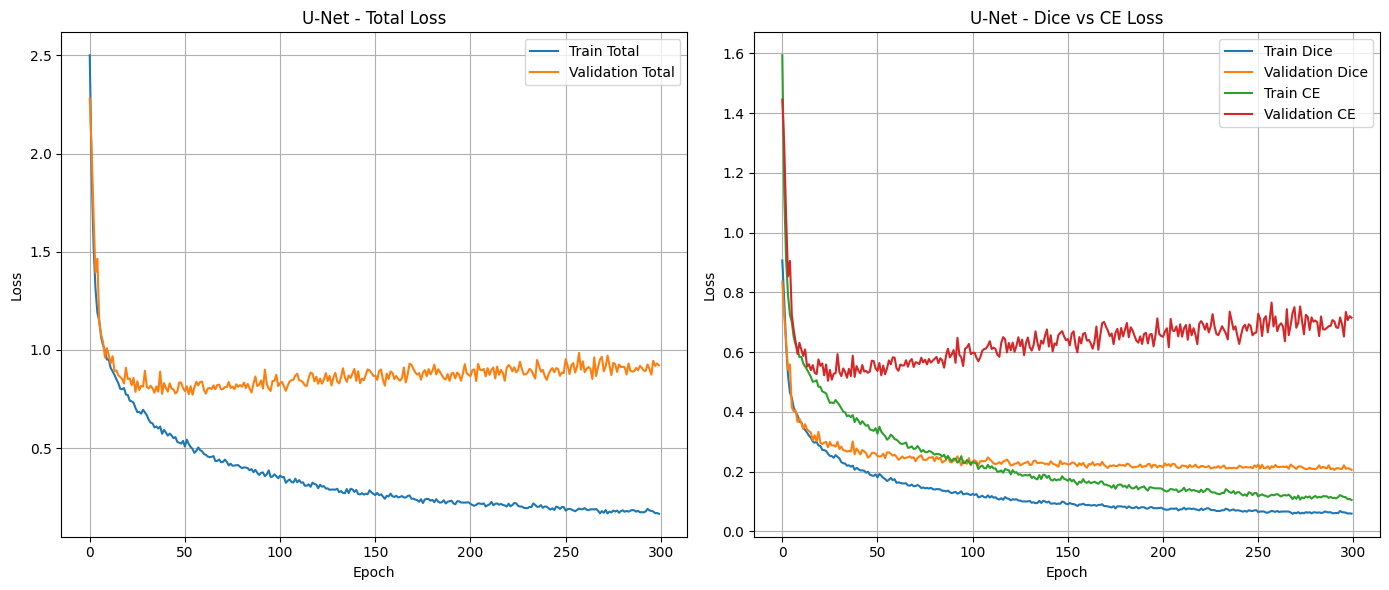

In [4]:
plot_unet_training(unet_log_dir)

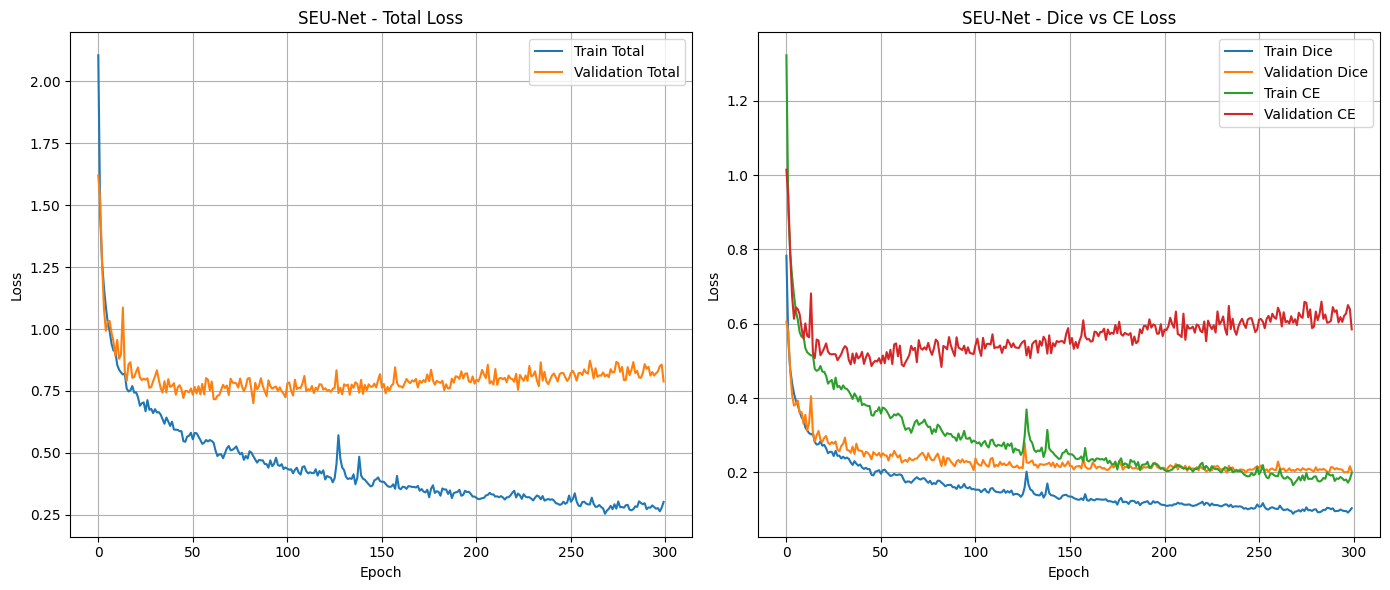

In [5]:
plot_unet_training(seunet_log_dir, model_name='SEU-Net')

In [33]:
# Set this to your actual path
dataset_dir = "/content/drive/MyDrive/dentex_dataset/segmentation/enumeration9"  # Should contain image_names.json, xrays/, masks/
unet_ckpt = "/content/drive/MyDrive/output_unet_enum9_07-26_10-25/epoch_38_loss_0.7756352759897709.pth"
seunet_ckpt = "/content/drive/MyDrive/output_seunet_enum9_07-26_17-00/epoch_45_loss_0.721814745105803.pth"

In [7]:
# Load and split dataset
dataset = Preload(SegmentationDataset(dataset_dir))
transformed_dataset = TransformedDataset(dataset, flip=0.1, crop=0.1, rotate=[-10, 10])

# Use the same seed and split ratio as in training
val_size = int(len(transformed_dataset) * 0.2)
train_size = len(transformed_dataset) - val_size
_, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size],
                                               generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [24]:
# -------------------- U-Net --------------------
from models.unet.UNet import UNet
from models.unet.SE_UNet import SEUNet

# U-Net model for 9 classes (0–7 + out-of-quadrant)
unet_model = UNet(in_channels=1, out_channels=10).cuda()

# Load U-Net checkpoint
unet_ckpt = torch.load('/content/drive/MyDrive/output_unet_enum9_07-26_10-25/epoch_54_loss_0.7716688476502895.pth')
unet_model.load_state_dict(unet_ckpt["model_state_dict"])

# Evaluate U-Net
iou_u, dice_u, iou_u_per_class, dice_u_per_class = evaluate_segmentation_model_enum9(unet_model, val_loader, num_classes=9)

# -------------------- SE-U-Net --------------------
seunet_model = SEUNet(n_cls=10).cuda()

# Load SE-U-Net checkpoint
seunet_ckpt = torch.load("/content/drive/MyDrive/output_seunet_enum9_07-26_17-00/epoch_15_loss_0.7904867241159081.pth")
seunet_model.load_state_dict(seunet_ckpt["model_state_dict"])

# Evaluate SE-U-Net
iou_se, dice_se, iou_se_per_class, dice_se_per_class = evaluate_segmentation_model_enum9(seunet_model, val_loader, num_classes=9)

# -------------------- Results --------------------
print("Evaluation Results:")
print(f"U-Net    => Mean IoU: {iou_u:.4f}, Mean Dice: {dice_u:.4f}")
print(f"SE-U-Net => Mean IoU: {iou_se:.4f}, Mean Dice: {dice_se:.4f}")

# Optional: print per-class Dice (e.g., teeth 0–7, and out-of-quadrant)
print("\nPer-Class Dice Scores (U-Net):")
for cls_id, dice in enumerate(dice_u_per_class):
    print(f"  Class {cls_id}: {dice:.4f}")

print("\nPer-Class Dice Scores (SE-U-Net):")
for cls_id, dice in enumerate(dice_se_per_class):
    print(f"  Class {cls_id}: {dice:.4f}")


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 23.07it/s]

Evaluation Results:
U-Net    => Mean IoU: 0.6596, Mean Dice: 0.7589
SE-U-Net => Mean IoU: 0.6575, Mean Dice: 0.7564

Per-Class Dice Scores (U-Net):
  Class 0: 0.8507
  Class 1: 0.8106
  Class 2: 0.7867
  Class 3: 0.7762
  Class 4: 0.7345
  Class 5: 0.7418
  Class 6: 0.7395
  Class 7: 0.7438
  Class 8: 0.6460

Per-Class Dice Scores (SE-U-Net):
  Class 0: 0.8564
  Class 1: 0.8006
  Class 2: 0.7643
  Class 3: 0.7509
  Class 4: 0.7321
  Class 5: 0.7159
  Class 6: 0.7487
  Class 7: 0.7570
  Class 8: 0.6818


In [18]:
# U-Net
unet_results = evaluate_all_checkpoints(
    model_class=UNet,
    checkpoint_dir="/content/drive/MyDrive/output_unet_enum9_07-26_10-25",
    val_loader=val_loader,
    model_name="UNet",
)

Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.14it/s]


[UNet] epoch_0_loss_2.281249698251486.pth => IoU: 0.1655, Dice: 0.2313


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.04it/s]


[UNet] epoch_11_loss_0.9315261133015156.pth => IoU: 0.6046, Dice: 0.7081


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.34it/s]


[UNet] epoch_13_loss_0.892965130507946.pth => IoU: 0.6262, Dice: 0.7283


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.06it/s]


[UNet] epoch_15_loss_0.870538417249918.pth => IoU: 0.6275, Dice: 0.7297


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.00it/s]


[UNet] epoch_16_loss_0.8619282450526953.pth => IoU: 0.6363, Dice: 0.7393


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.54it/s]


[UNet] epoch_17_loss_0.8527662269771099.pth => IoU: 0.6452, Dice: 0.7463


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.07it/s]


[UNet] epoch_18_loss_0.8287881780415773.pth => IoU: 0.6462, Dice: 0.7466


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.40it/s]


[UNet] epoch_1_loss_2.016341283917427.pth => IoU: 0.2795, Dice: 0.3698


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.34it/s]


[UNet] epoch_22_loss_0.8198983334004879.pth => IoU: 0.6458, Dice: 0.7473


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.06it/s]


[UNet] epoch_24_loss_0.7862503230571747.pth => IoU: 0.6697, Dice: 0.7668


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.79it/s]


[UNet] epoch_2_loss_1.6879292838275433.pth => IoU: 0.3433, Dice: 0.4552


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.96it/s]


[UNet] epoch_34_loss_0.7818149849772453.pth => IoU: 0.6755, Dice: 0.7732


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.45it/s]


[UNet] epoch_38_loss_0.7756352759897709.pth => IoU: 0.6802, Dice: 0.7774


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.01it/s]


[UNet] epoch_3_loss_1.3946398012340069.pth => IoU: 0.4461, Dice: 0.5569


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.66it/s]


[UNet] epoch_52_loss_0.7740027625113726.pth => IoU: 0.6743, Dice: 0.7724


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.38it/s]


[UNet] epoch_54_loss_0.7716688476502895.pth => IoU: 0.6709, Dice: 0.7694


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 31.98it/s]


[UNet] epoch_5_loss_1.1393745262175798.pth => IoU: 0.5317, Dice: 0.6437


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.25it/s]


[UNet] epoch_6_loss_1.076202005147934.pth => IoU: 0.5596, Dice: 0.6722


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.10it/s]


[UNet] epoch_7_loss_1.038669789209962.pth => IoU: 0.5873, Dice: 0.6931


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 32.82it/s]


[UNet] epoch_8_loss_0.9607153180986643.pth => IoU: 0.5989, Dice: 0.7047


Evaluating: 100%|██████████| 127/127 [00:03<00:00, 33.30it/s]

[UNet] last_epoch.pth => IoU: 0.6921, Dice: 0.7882


In [21]:
# SE-U-Net
seunet_results = evaluate_all_checkpoints(
    model_class=SEUNet,
    checkpoint_dir="/content/drive/MyDrive/output_seunet_enum9_07-26_17-00",
    val_loader=val_loader,
    model_name="SEUNet",
)

Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.13it/s]


[SEUNet] epoch_0_loss_1.619971163570881.pth => IoU: 0.3837, Dice: 0.5089


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.58it/s]


[SEUNet] epoch_11_loss_0.8802905650809407.pth => IoU: 0.6395, Dice: 0.7408


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.10it/s]


[SEUNet] epoch_14_loss_0.8303428050130606.pth => IoU: 0.6432, Dice: 0.7426


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.19it/s]


[SEUNet] epoch_15_loss_0.7904867241159081.pth => IoU: 0.6518, Dice: 0.7492


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.05it/s]


[SEUNet] epoch_1_loss_1.51856180280447.pth => IoU: 0.4140, Dice: 0.5339


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.27it/s]


[SEUNet] epoch_27_loss_0.7624699166044593.pth => IoU: 0.6750, Dice: 0.7717


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 21.62it/s]


[SEUNet] epoch_2_loss_1.2623432409018278.pth => IoU: 0.5019, Dice: 0.6155


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.40it/s]


[SEUNet] epoch_33_loss_0.7614604970440269.pth => IoU: 0.6738, Dice: 0.7714


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.18it/s]


[SEUNet] epoch_34_loss_0.7435886841267347.pth => IoU: 0.6799, Dice: 0.7782


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.52it/s]


[SEUNet] epoch_36_loss_0.7435412621125579.pth => IoU: 0.6819, Dice: 0.7782


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 21.72it/s]


[SEUNet] epoch_3_loss_1.0823468398302794.pth => IoU: 0.5655, Dice: 0.6724


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.09it/s]


[SEUNet] epoch_41_loss_0.7349456613883376.pth => IoU: 0.6851, Dice: 0.7814


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.45it/s]


[SEUNet] epoch_45_loss_0.721814745105803.pth => IoU: 0.6982, Dice: 0.7941


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.07it/s]


[SEUNet] epoch_4_loss_0.9932010751217604.pth => IoU: 0.5847, Dice: 0.6881


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.35it/s]


[SEUNet] epoch_61_loss_0.7171527929604053.pth => IoU: 0.6933, Dice: 0.7905


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.49it/s]


[SEUNet] epoch_62_loss_0.7166651701554656.pth => IoU: 0.6943, Dice: 0.7899


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.54it/s]


[SEUNet] epoch_7_loss_0.9849597755819559.pth => IoU: 0.6202, Dice: 0.7222


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.33it/s]


[SEUNet] epoch_82_loss_0.7009029621258378.pth => IoU: 0.6974, Dice: 0.7936


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.15it/s]


[SEUNet] epoch_8_loss_0.9508495088666677.pth => IoU: 0.6130, Dice: 0.7170


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.06it/s]


[SEUNet] epoch_9_loss_0.8922512475401163.pth => IoU: 0.6188, Dice: 0.7205


Evaluating: 100%|██████████| 127/127 [00:05<00:00, 22.04it/s]

[SEUNet] last_epoch.pth => IoU: 0.6982, Dice: 0.7949


In [22]:
# Sort results by mean Dice score (descending)
best_unet = sorted(unet_results, key=lambda x: x[2], reverse=True)
best_seunet = sorted(seunet_results, key=lambda x: x[2], reverse=True)

print("\n🔝 Top U-Net Checkpoints (by Dice):")
for ckpt, iou, dice in best_unet[:3]:
    print(f"{ckpt}: IoU = {iou:.4f}, Dice = {dice:.4f}")

print("\n🔝 Top SE-U-Net Checkpoints (by Dice):")
for ckpt, iou, dice in best_seunet[:3]:
    print(f"{ckpt}: IoU = {iou:.4f}, Dice = {dice:.4f}")



🔝 Top U-Net Checkpoints (by Dice):
last_epoch.pth: IoU = 0.6921, Dice = 0.7882
epoch_38_loss_0.7756352759897709.pth: IoU = 0.6802, Dice = 0.7774
epoch_34_loss_0.7818149849772453.pth: IoU = 0.6755, Dice = 0.7732

🔝 Top SE-U-Net Checkpoints (by Dice):
last_epoch.pth: IoU = 0.6982, Dice = 0.7949
epoch_45_loss_0.721814745105803.pth: IoU = 0.6982, Dice = 0.7941
epoch_82_loss_0.7009029621258378.pth: IoU = 0.6974, Dice = 0.7936


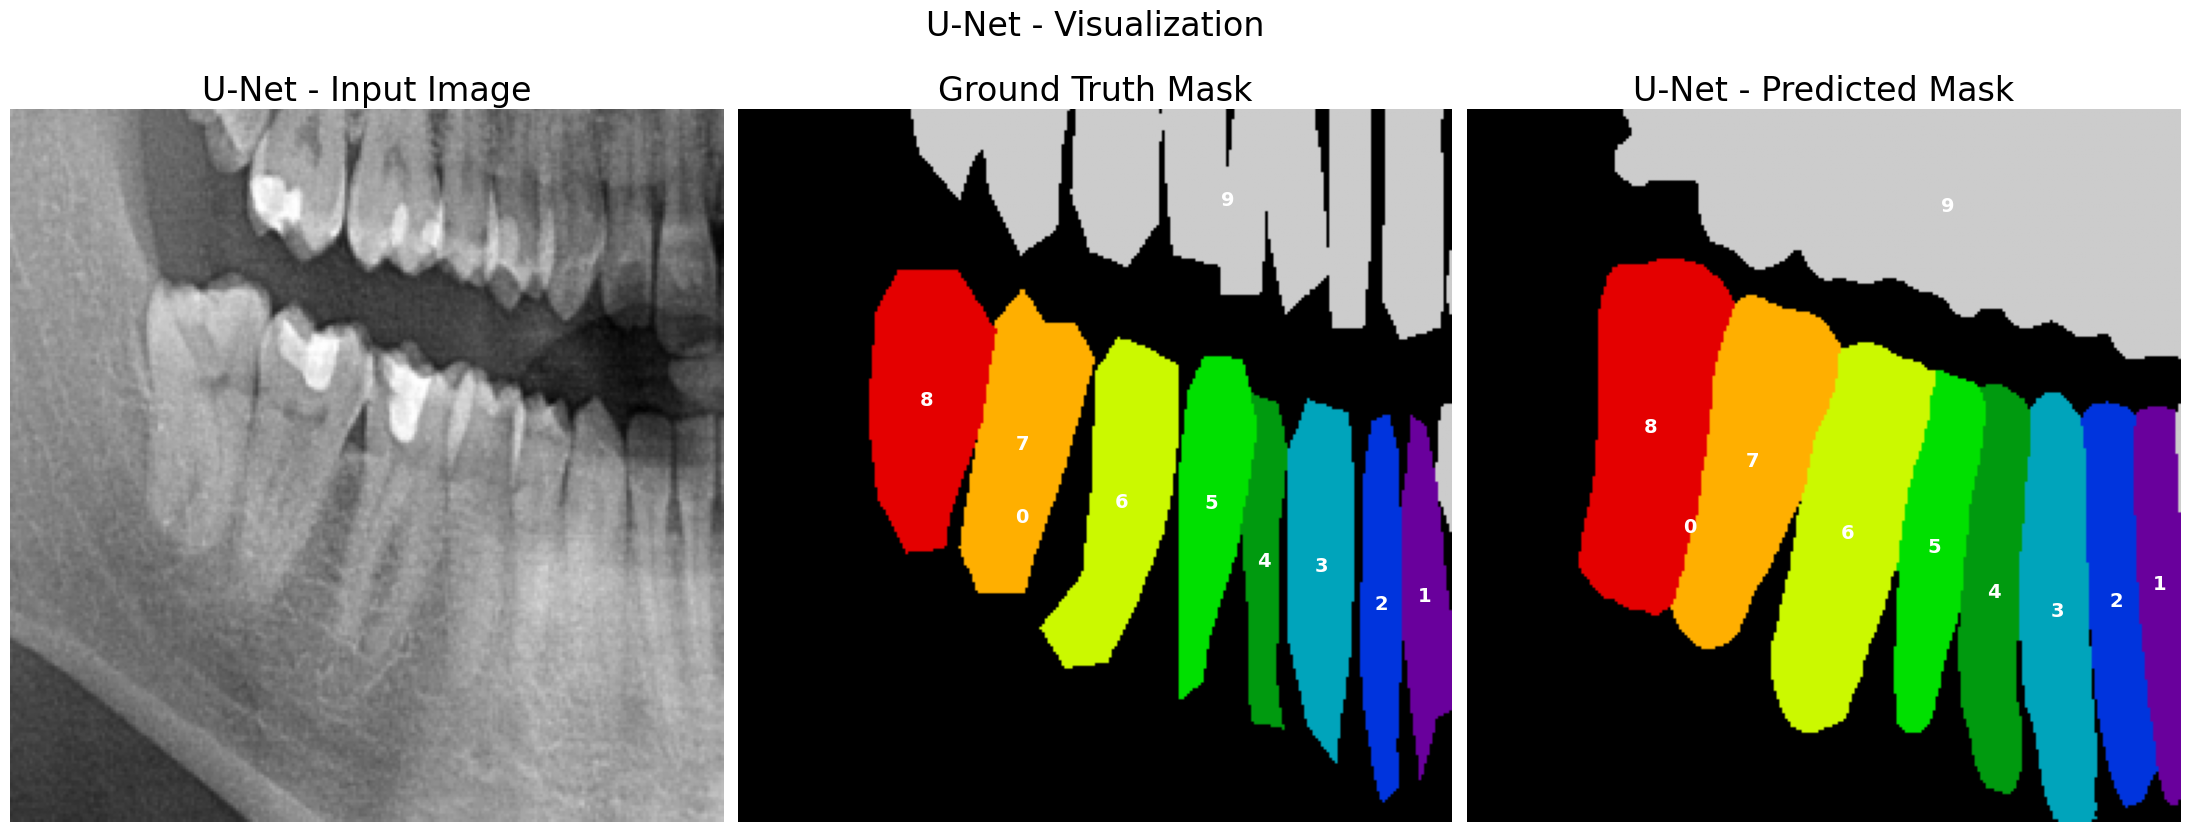

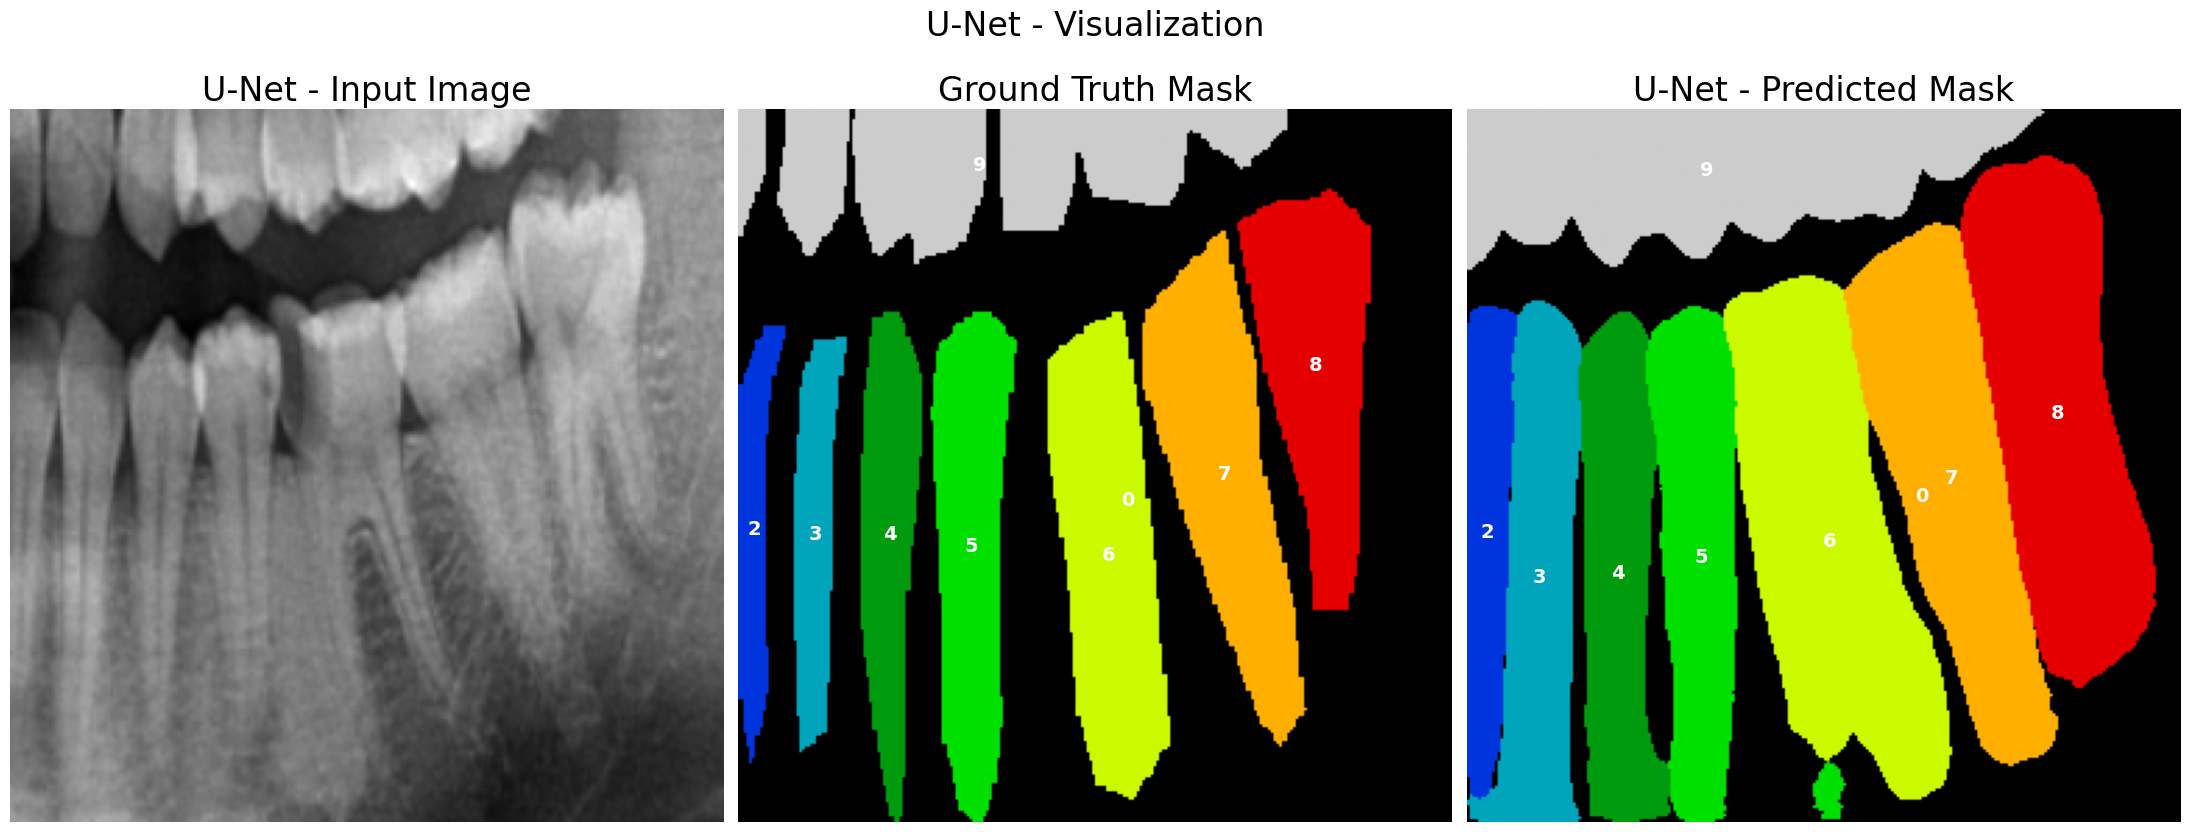

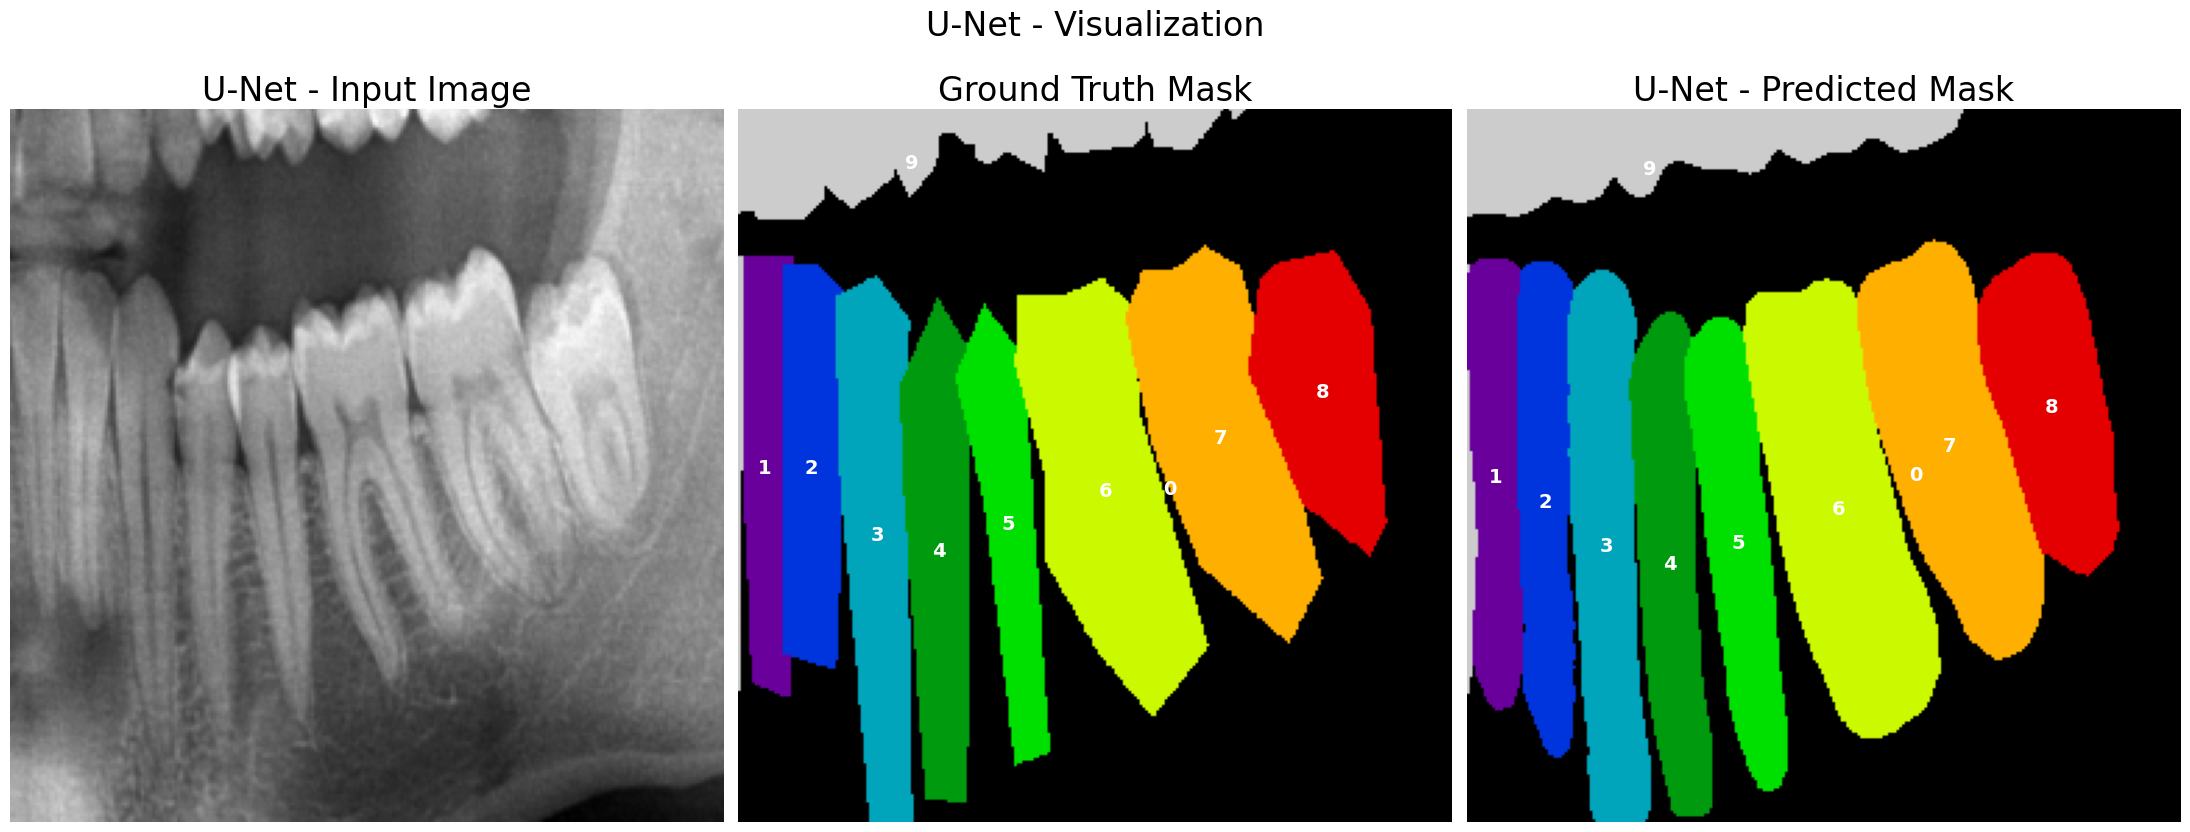

In [27]:
visualize_model_predictions(unet_model, val_dataset, model_name="U-Net")

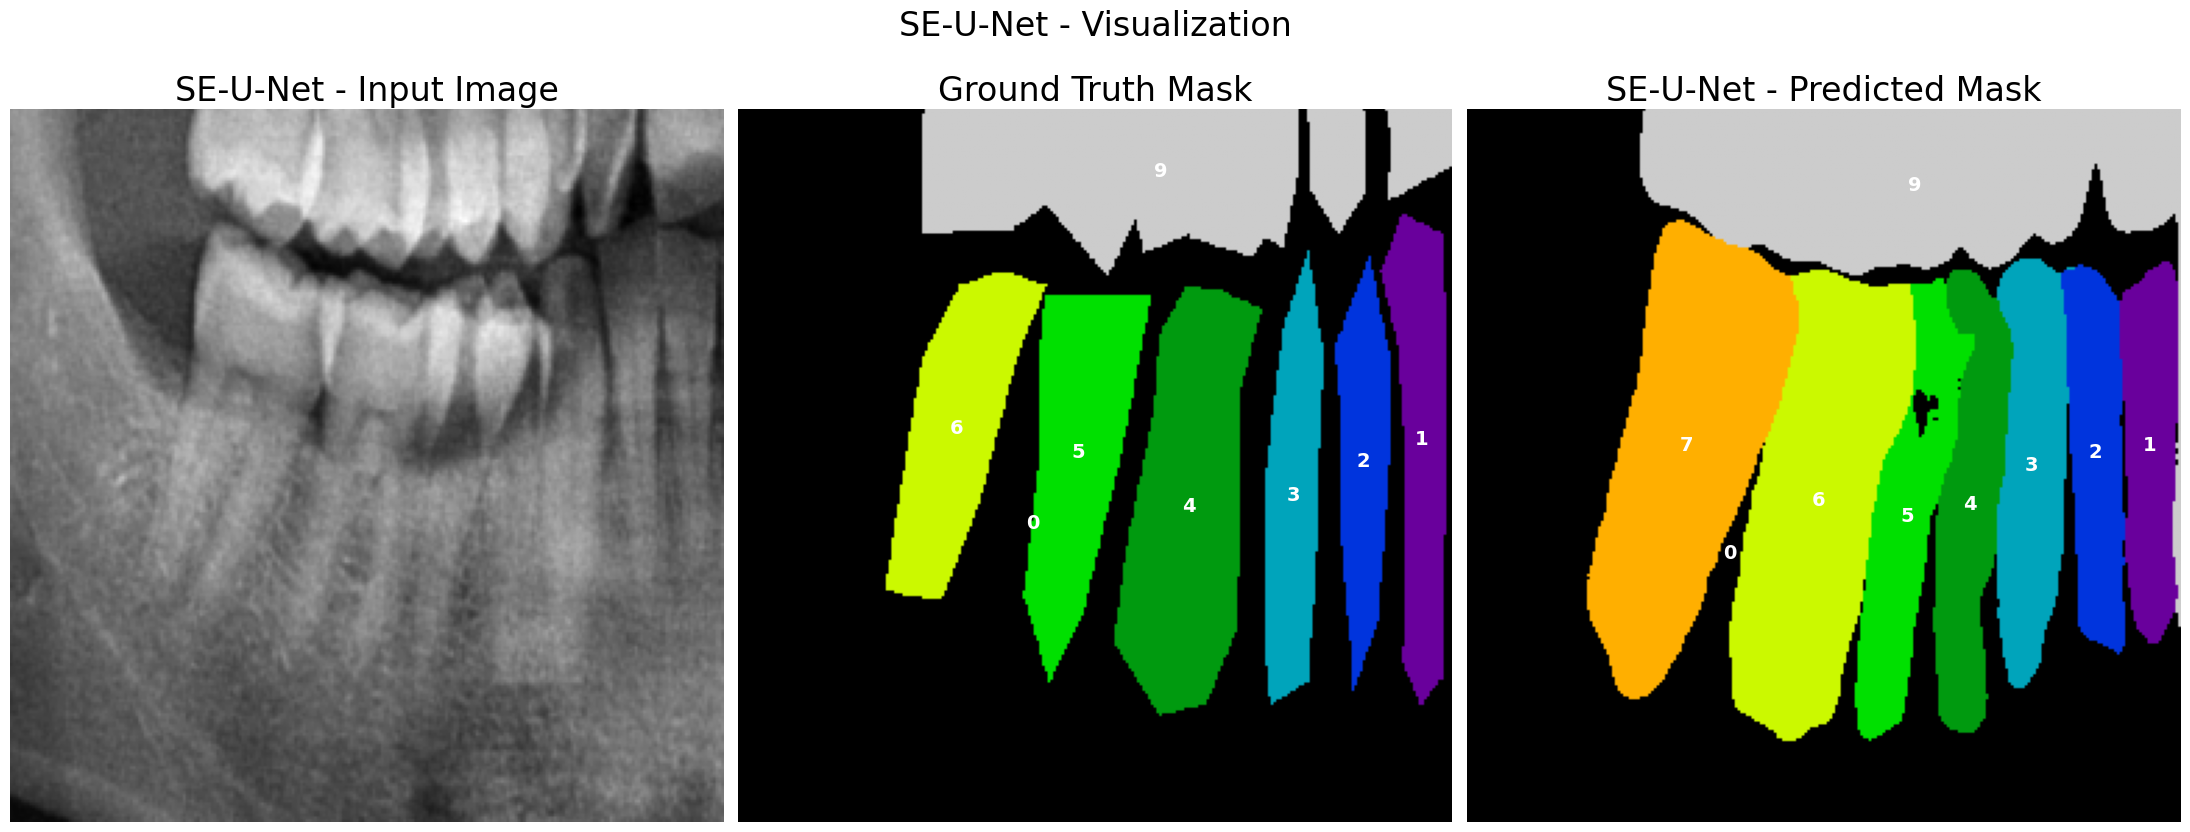

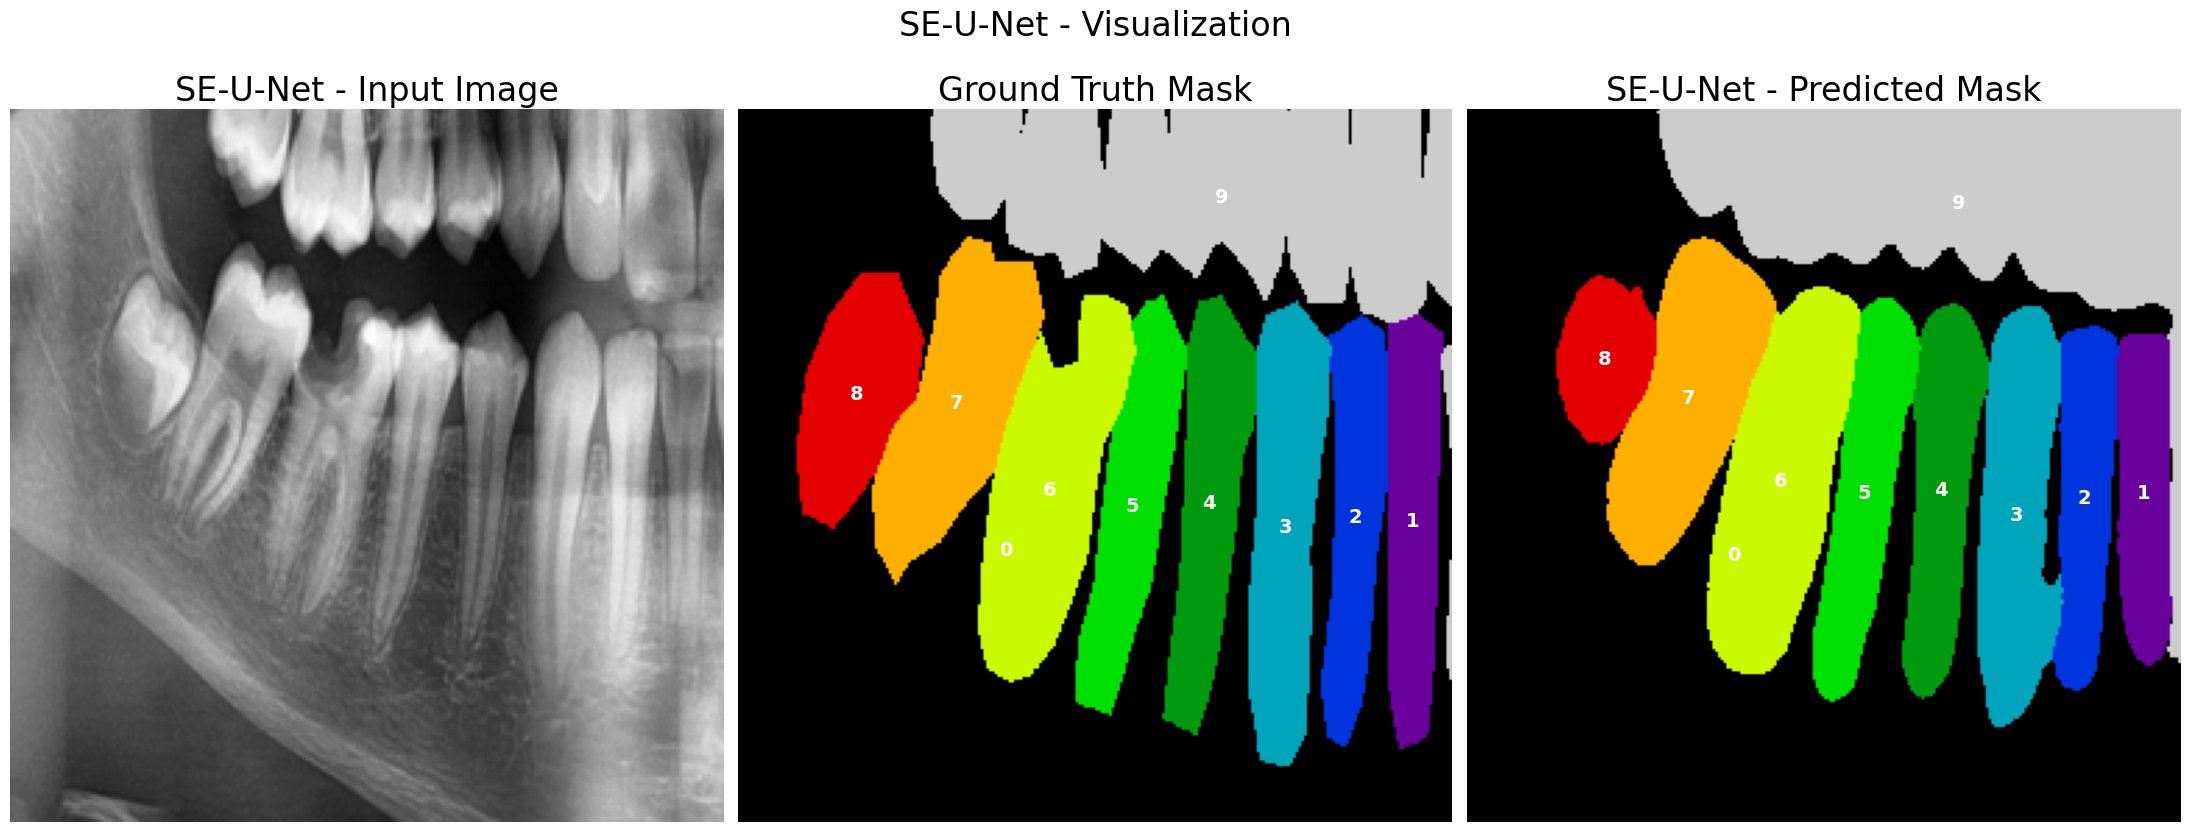

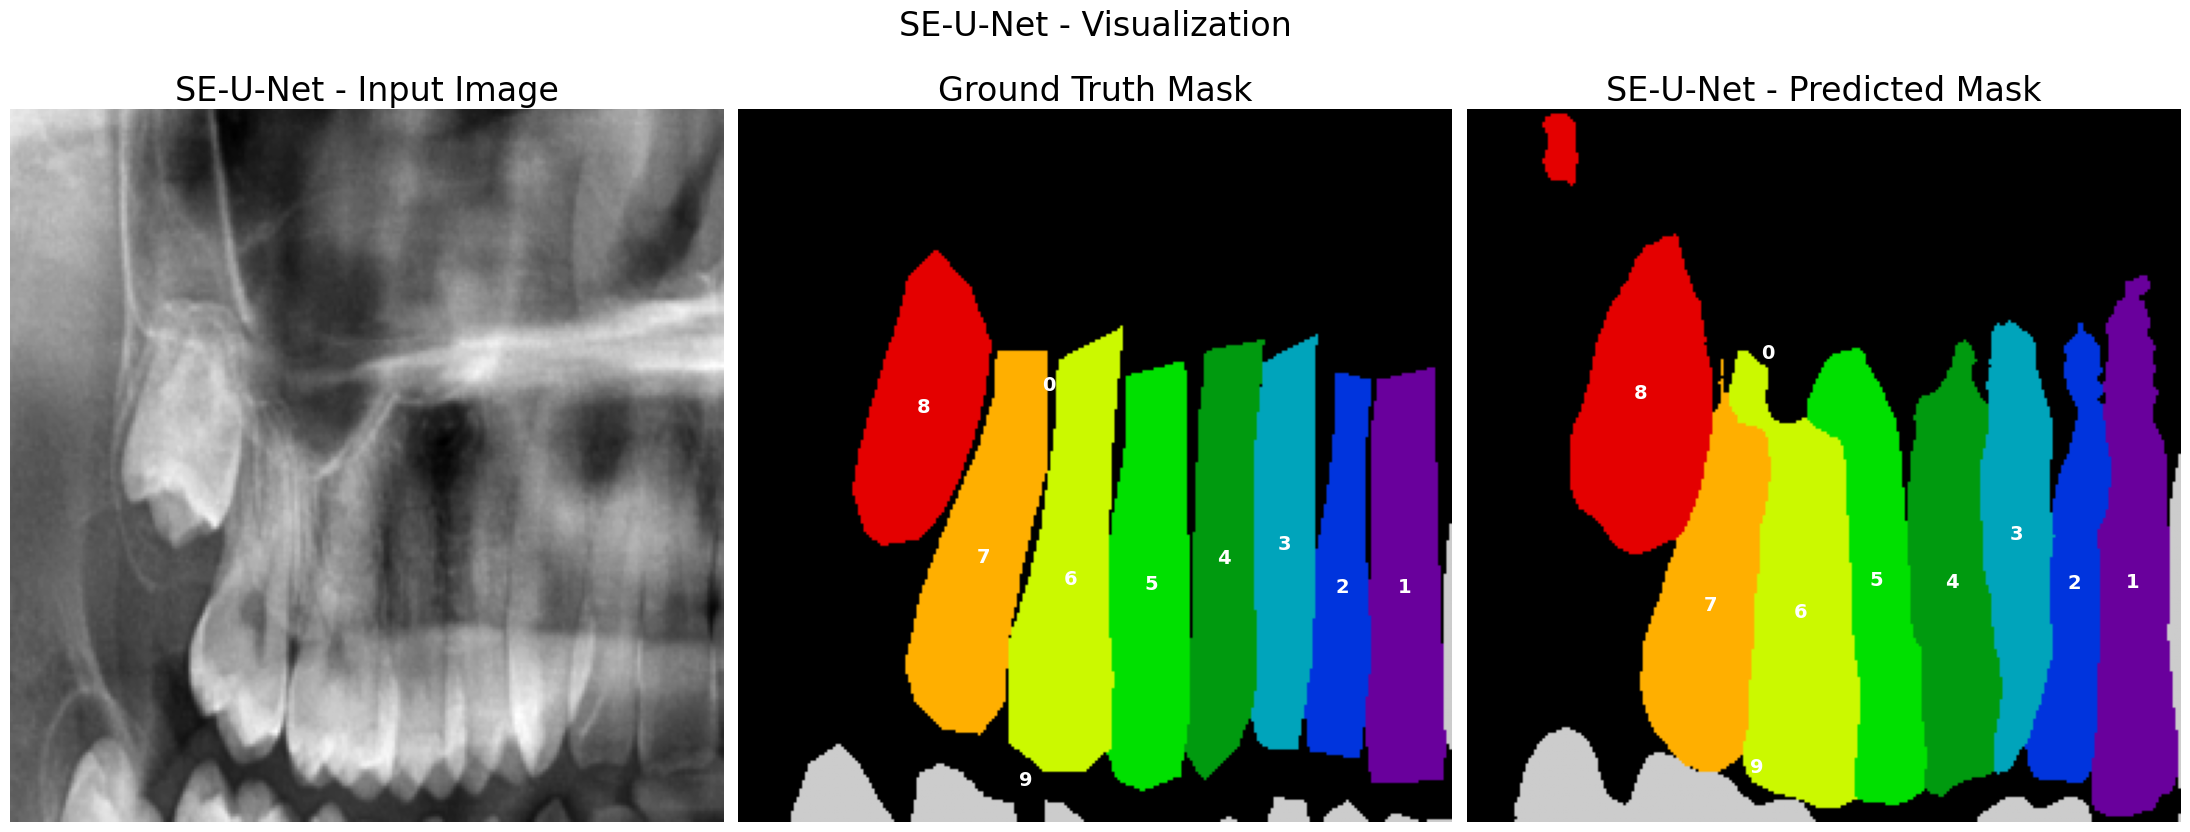

In [32]:
visualize_model_predictions(seunet_model, val_dataset, model_name="SE-U-Net")